## 准备工作
### 首先导入库文件和函数

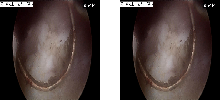

原始手术视频     处理之后视频


In [ ]:
import sys
import math
import numpy as np
import os
import time
import PIL
from PIL import Image
from matplotlib import pyplot
import cv2
from datetime import datetime
from pynq import Xlnk
from pynq import Overlay
from pynq.mmio import MMIO
import scipy.misc
import IPython
from IPython.display import display
#import pandas as pd

img_folder = '../FPS_1/'
frame_w = 60
frame_h = 45

#pd.set_option('display.max_columns', None)
#pd.set_option('max_columns',1000)
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
OVERLAY_PATH = '/home/xilinx/jupyter_notebooks/prostatectomy/deploy/procsys_wrapper.bit'
overlay = Overlay(OVERLAY_PATH)
dma = overlay.axi_dma_0
# WEIGHTS_FILE_NAME = '/home/xilinx/jupyter_notebooks/prostatectomy/deploy/weights_file.txt'
WEIGHTS_FILE_NAME = '/home/xilinx/jupyter_notebooks/prostatectomy/deploy/weights_file_new.txt'
xlnk = Xlnk()
nn_ctrl = MMIO(0x43c00000, length=1024)
print('Got nn_ctrl!')

## 分配 Buffers
MINIBATCH_SIZE = 1
height = 224
width = 224
pixel_bits = 24
pixels_per_line = 384/pixel_bits
num_lines = int((height*width)/pixels_per_line)
in_buffer = xlnk.cma_array(shape=(MINIBATCH_SIZE*num_lines, 64), dtype=np.uint8)
# display(in_buffer)

# in_buffer = xlnk.cma_array(shape=(MINIBATCH_SIZE*num_lines, 64), dtype=np.uint8)
# display(in_buffer)
fire1_num_out_lines = 28*28*MINIBATCH_SIZE
fire1_out_buffer = xlnk.cma_array(shape=(int(16*fire1_num_out_lines),), dtype=np.uint32)
fire2345_num_out_lines = 14*14*MINIBATCH_SIZE
fire2_out_buffer = xlnk.cma_array(shape=(int(16*fire2345_num_out_lines),), dtype=np.uint32)
fire3_out_buffer = xlnk.cma_array(shape=(int(16*fire2345_num_out_lines),), dtype=np.uint32)
bndboxes = xlnk.cma_array(shape=(int(MINIBATCH_SIZE),16), dtype=np.int32)

## Allocate SW weight buffers and load from text file
weights_file = open(WEIGHTS_FILE_NAME, "r")
layer = 0
squeeze_weight_iterations = np.zeros(7)
expand_weight_iterations = np.zeros(7)
squeeze_factor_iterations = np.zeros(7)
expand_factor_iterations = np.zeros(7)
for line in weights_file:
    if "layer" in line:
        temp = line.split(": ")
        layer = int(temp[1])
    if "squeeze_weight_iterations" in line:
        temp = line.split(": ")
        squeeze_weight_iterations[layer] = int(temp[1])
    if "expand_weight_iterations" in line:
        temp = line.split(": ")
        expand_weight_iterations[layer] = int(temp[1])
    if "squeeze_factor_iterations" in line:
        temp = line.split(": ")
        squeeze_factor_iterations[layer] = int(temp[1])
    if "expand_factor_iterations" in line:
        temp = line.split(": ")
        expand_factor_iterations[layer] = int(temp[1])
weights_file.close()
weightfactors_length = np.zeros(7)
for i in range(0, 7):
    weightfactors_length[i] = int(squeeze_weight_iterations[i] + \
                                expand_weight_iterations[i] + \
                                squeeze_factor_iterations[i] + \
                                expand_factor_iterations[i])
weightsfactors = []
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[0]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[1]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[2]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[3]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[4]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[5]),), dtype=np.uint32) )
weightsfactors.append( xlnk.cma_array(shape=(int(16*weightfactors_length[6]),), dtype=np.uint32) )
index = 0
weights_file = open(WEIGHTS_FILE_NAME, "r")
for line in weights_file:
    if "layer" in line:
        temp = line.split(": ")
        layer = int(temp[1])
        index = 0
    elif "squeeze_weight_iterations" not in line and \
            "expand_weight_iterations" not in line and \
            "squeeze_factor_iterations" not in line and \
            "expand_factor_iterations" not in line:
        no0x = line.split('0x')[-1]
        base = 1
        while base < len(no0x):
            part = no0x[-1*(base+8):-1*base]    
            weightsfactors[layer][index*16 + int(base/8)] = int(part, 16)
            base += 8
        index += 1

## 定义转移函数
def weightsfactors_transfer(weightsfactors):
    nn_ctrl.write(0x68, 13)
    nn_ctrl.write(0x70, 0)
    nn_ctrl.write(0x0, 0) # Reset
    nn_ctrl.write(0x0, 1) # Deassert reset
    dma.sendchannel.transfer(weightsfactors)
    dma.sendchannel.wait()
    
## 定义
def fire(inbuffer, outbuffer, 
         squeeze_din, squeeze_cin, squeeze_cout, 
         expand_din, expand_din_afterpool, expand_cin, expand_cout, 
         whichfire):
    nn_ctrl.write(0x0, 0) # Reset
    nn_ctrl.write(0x10, squeeze_din)
    nn_ctrl.write(0x18, squeeze_cin)
    nn_ctrl.write(0x20, squeeze_cout)
    nn_ctrl.write(0x28, 0)
    nn_ctrl.write(0x30, 0)
    nn_ctrl.write(0x38, expand_din)
    nn_ctrl.write(0x40, expand_din_afterpool)
    nn_ctrl.write(0x48, expand_cin)
    nn_ctrl.write(0x50, expand_cout)
    nn_ctrl.write(0x58, 0)
    nn_ctrl.write(0x60, 0)
    nn_ctrl.write(0x68, whichfire)
    nn_ctrl.write(0x70, MINIBATCH_SIZE) # set numReps
    nn_ctrl.write(0x0, 1) # Deassert reset
    dma.recvchannel.transfer(outbuffer)
    dma.sendchannel.transfer(inbuffer)
    
num_images = 1
result = xlnk.cma_array(shape=(int(num_images),5), dtype=np.int32)
display(result)

img_file = os.path.join(img_folder, 'white.jpg')
white_int = cv2.imread(img_file)
white = cv2.resize(white_int, dsize=(20,100), interpolation=cv2.INTER_CUBIC)

n_frame = 1000
for i in range(n_frame):
# while(1):
#         i=43
        start_all=time.time() 
        start_read=time.time() 
#########################################循环读入图片（resize给定的宽高，并转成矩阵###################################
        img_file = os.path.join(img_folder, str(i+1) + '.jpg')
        frame_int = cv2.imread(img_file)
        frame = cv2.resize(frame_int, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
        frame_ori = frame_int
        frame_ori = cv2.resize(frame_ori, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
        frame_vga_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = cv2.resize(frame_vga_rgb, (height, width))   # 转为224*224      
        in_buffer[0:num_lines,0:48] = np.reshape(image, (num_lines, 48))  # 将224*224矩阵存入buffer 
        end_read=time.time() 
        
#######################################对矩阵进行存储在buffer里的矩阵运算###############################################
        start_process=time.time()         
        weightsfactors_transfer(weightsfactors[0])  #weightfactors[0]传送至FPGA本地存储器（BRAM）
        fire(in_buffer, fire1_out_buffer,  #将存入buffer的224*224矩阵数据流传输至DMA，并执行CNN的第一部分
         56, 32, 32, 56, 28, 32, 96, 1)
        dma.recvchannel.wait()
        
        weightsfactors_transfer(weightsfactors[1])
        fire(fire1_out_buffer, fire2_out_buffer,
         28, 96, 32, 28, 14, 32, 96, 2)
        dma.recvchannel.wait()

        weightsfactors_transfer(weightsfactors[2])
        fire(fire2_out_buffer, fire3_out_buffer,
        14, 96, 32, 14, 14, 32, 96, 3)
        dma.recvchannel.wait()

        weightsfactors_transfer(weightsfactors[3])
        fire(fire3_out_buffer, fire2_out_buffer,
        14, 96, 32, 14, 14, 32, 96, 4)
        dma.recvchannel.wait()

        weightsfactors_transfer(weightsfactors[4])
        fire(fire2_out_buffer, fire3_out_buffer,
        14, 96, 32, 14, 14, 32, 96, 5)
        dma.recvchannel.wait()

        weightsfactors_transfer(weightsfactors[5])
        fire(fire3_out_buffer, fire2_out_buffer,
        14, 96, 32, 14, 14, 32, 96, 6)
        dma.recvchannel.wait()

        weightsfactors_transfer(weightsfactors[6])
        fire(fire2_out_buffer, bndboxes,
        14, 96, 32, 14, 14, 32, 96, 7)
        dma.recvchannel.wait()      # 得到bounding box矩阵（具体代表什么还需进一步探索）           
        end_process=time.time()     #处理执行的时间节点
                
#display(bndboxes)
        
        start_compute=time.time()
        result[:,:] = bndboxes[:,0:5]      # 将bounding box里面第一张图片的内容抽取出来，赋值给result 
        result_rectangles = []
        float_objdetect = result[0,4].astype('float')
        float_bndboxes = result[0,0:4].astype('float')
        float_bndboxes = np.divide( float_bndboxes, float((1<<22)) )
        float_bndboxes *= 0x882065
        float_bndboxes = np.divide( float_bndboxes, float((1<<22)) )
#display(float_objdetect)
        
        obj_h = int(float_objdetect/14)
        obj_w = int(float_objdetect%14)  
        x_min = int(((float_bndboxes[0] + obj_w*16) *(80/width)))
        y_min = int(((float_bndboxes[1] + obj_h*16) *(80/height)))
        x_max = int(((float_bndboxes[2] + obj_w*16) *(80/width)))
        y_max = int(((float_bndboxes[3] + obj_h*16) *(80/height)))  # 将bounding box的值经过归一化，得到框的坐标位置
        end_compute=time.time()
        start_display=time.time()
#        print('原始手术视频 :') 
#        display(scipy.misc.toimage( cv2.cvtColor(frame_ori, cv2.COLOR_BGR2RGB) ))
        result_rectangles.append([x_min, x_max, y_min, y_max])
        end_all=time.time()
        if((x_min>10)&(y_min>8)):
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,255,0), 2)    #根据变换之后的坐标位置进行框框
            cv2.putText(frame, 'warning!', (x_min, y_min), cv2.FONT_HERSHEY_COMPLEX,0.5, (0,0,255),2)   # 在框的左上角标注“warning”
            cv2.putText(frame, str(int(1/(end_all-start_all+0.065)))+"FPS" , (160, 190), cv2.FONT_HERSHEY_PLAIN,0.8, (255,255,255),1)   # 在框的左上角标注“warning”
#        display(scipy.misc.toimage( cv2.cvtColor(frame_ori, cv2.COLOR_BGR2RGB) ),scipy.misc.toimage( cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) ))
#        print('处理之后视频 :')
#         display(( cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) ))
#        display('处理之后视频 :',scipy.misc.toimage( cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) ))
        display(scipy.misc.toimage(np.concatenate([cv2.cvtColor(frame_ori, cv2.COLOR_BGR2RGB),white,cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)],axis=1)))
#        print('原始手术视频     处理之后视频',i)
        print('原始手术视频     处理之后视频')
         
#        display(( cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) ))
#        end_display=time.time()
#        end_all_1=time.time()
#        print('\nReading a picture time:',end_read-start_read) 
#        print('Process a picture time:',end_process-start_process) 
#        print('Compute a picture time:',end_compute-start_compute) 
#        print('display a picture time:',end_display-start_display) 
#        print('All process time:',end_all_1-start_all) 
        IPython.display.clear_output(1)